In [5]:
import emnist
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import skimage
from skimage import io

label_ascii_map = np.loadtxt('./emnist-balanced-mapping.txt')

my_file = open("./winnie.txt", "r")
data = my_file.read()
my_file.close()

img_emnist, labels_emnist = emnist.extract_training_samples('bymerge')

img_kmnist = np.load('./kmnist/k49-train-imgs.npz')['arr_0']
labels_kmnist = np.load('./kmnist/k49-train-labels.npz')['arr_0']

In [17]:
shuffled = list(range(47))
random.shuffle(shuffled)
np.savetxt("emnist_kmnist_coding.csv", shuffled, fmt="%d", delimiter=",")

labels_kmnist_coded = []

for x in labels_kmnist:
    if x < len(shuffled):
        labels_kmnist_coded.append(shuffled[x])
    else:
        labels_kmnist_coded.append(-1)

In [18]:
blank_space = np.full((32, 32), 255)

emnist_img_label_map = {}
for label in np.unique(labels_emnist):
    emnist_img_label_map[label] = np.where(labels_emnist == label)[0]

kmnist_img_label_map = {}
for label in np.unique(labels_kmnist_coded):
    if label < len(shuffled):
        kmnist_img_label_map[label] = np.where(labels_kmnist_coded == label)[0]

In [19]:
def ascii_to_emnist_id(ascii):
    return label_ascii_map[np.where(label_ascii_map[:,1] == ascii)][0][0]

In [20]:
ascii_in_emnist = label_ascii_map[:,1]

missing_letters = [
    99, 105, 106, 
    107, 108, 109, 
    111, 112, 115, 
    117, 118, 119, 
    120, 121, 122
]

winnie_wo_missing = [letter if ord(letter) not in missing_letters else chr(ord(letter)-32) for letter in data]
winnie_wo_missing = ''.join(winnie_wo_missing)
winnie_wo_missing = winnie_wo_missing.split("\n")

winnie_ascii = []
for line_num in range(len(winnie_wo_missing)):
    line = [ord(x) if ord(x) in ascii_in_emnist else -1 for x in [*winnie_wo_missing[line_num]]]
    winnie_ascii.append(line)

In [21]:
def translate_ascii_to_label(winnie_ascii):
    blank_line = [-1] * 80
    pages_num = math.ceil(len(winnie_ascii)/114)
    book = []
    for page_num in range(pages_num):
        new_page = []

        for line in winnie_ascii[page_num*114:(page_num+1)*114]:
            new_line = []
            
            for letter in line:
                if letter == -1:
                    new_line.append(-1) 

                else:
                    e_id = ascii_to_emnist_id(letter)
                    new_line.append(e_id)

            while len(new_line) < 80:
                new_line.append(-1) 

            new_page.append(new_line)

        while len(new_page) < 114:
            new_page.append(blank_line)

        book.append(new_page)

    return np.array(book)

winnie_label = translate_ascii_to_label(winnie_ascii)

In [1]:
def letter_augmentation(image):
    canvas = np.zeros((32,32))

    new_image = image

    is_rotated = random.randint(1,10) <= 3
    is_trasnformed = random.randint(1,10) <= 3
    is_rotated = False
    is_trasnformed = False

    if is_rotated:
        angle = random.randint(-30, 30)	
        # angle = random.randint(-5, 5)	
        new_image = skimage.transform.rotate(image, angle, preserve_range=True)

    if is_trasnformed:
        is_xaxis = random.randint(0,1) == 0
        degree = random.randint(-15, 15)/100
        # degree = random.randint(-4, 4)/100

        if is_xaxis:        
            new_image = skimage.transform.rescale(new_image, (1+degree,1), preserve_range=True)
        else:
            new_image = skimage.transform.rescale(new_image, (1,1+degree), preserve_range=True)
        
    shape = new_image.shape

    x_center = (32 - shape[1]) // 2
    y_center = (32 - shape[0]) // 2

    canvas[y_center:y_center+shape[0], x_center:x_center+shape[1]] = new_image

    return 255 - canvas

def page_augmentation(input_page):

    page = input_page.copy()
    # page = skimage.util.random_noise(page,mode='s&p',clip=False)
    page[page > 255/2] = 255
    page[page <= 255/2] = 0
    page = 255 - page # white letters on black background
    
    return page

In [2]:
def generate(winnie_label, is_emnist=True):

    book = []

    pages_num = winnie_label.shape[0]

    for page_num in range(pages_num):
        new_page = []
        for line in winnie_label[page_num]:
            new_line = []
            for letter in line:
                if letter == -1:
                    new_line.append(blank_space) 

                else:
                    if is_emnist:
                        random_id = random.choice(emnist_img_label_map[letter])
                        # random_id = emnist_img_label_map[letter][4]
                        new_letter = img_emnist[random_id]

                    else:
                        random_id = random.choice(kmnist_img_label_map[letter])
                        # random_id = kmnist_img_label_map[letter][4]
                        new_letter = img_kmnist[random_id]

                    new_line.append(letter_augmentation(new_letter))
                
            while len(new_line) < 80:
                new_line.append(blank_space) 

            new_line = np.concatenate(new_line, axis=1) 
            new_page.append(new_line)

        new_page = np.concatenate(new_page, axis=0) 
        
        book.append(new_page)
    return book

def save_book(book, is_emnist=True):

    for page_num in range(len(book)):
        page = page_augmentation(book[page_num])
        im = Image.fromarray(page)
        im = im.convert('RGB')
        if is_emnist:
            path = './winnie-emnist-3/'
        else:
            path = './winnie-kmnist-3/'
        im.save(f'{path}{page_num}.png')


In [3]:
# is_emnist = False
for is_emnist in [True,False]:
    book = generate(winnie_label, is_emnist=is_emnist)
    save_book(book, is_emnist=is_emnist)

NameError: name 'winnie_label' is not defined

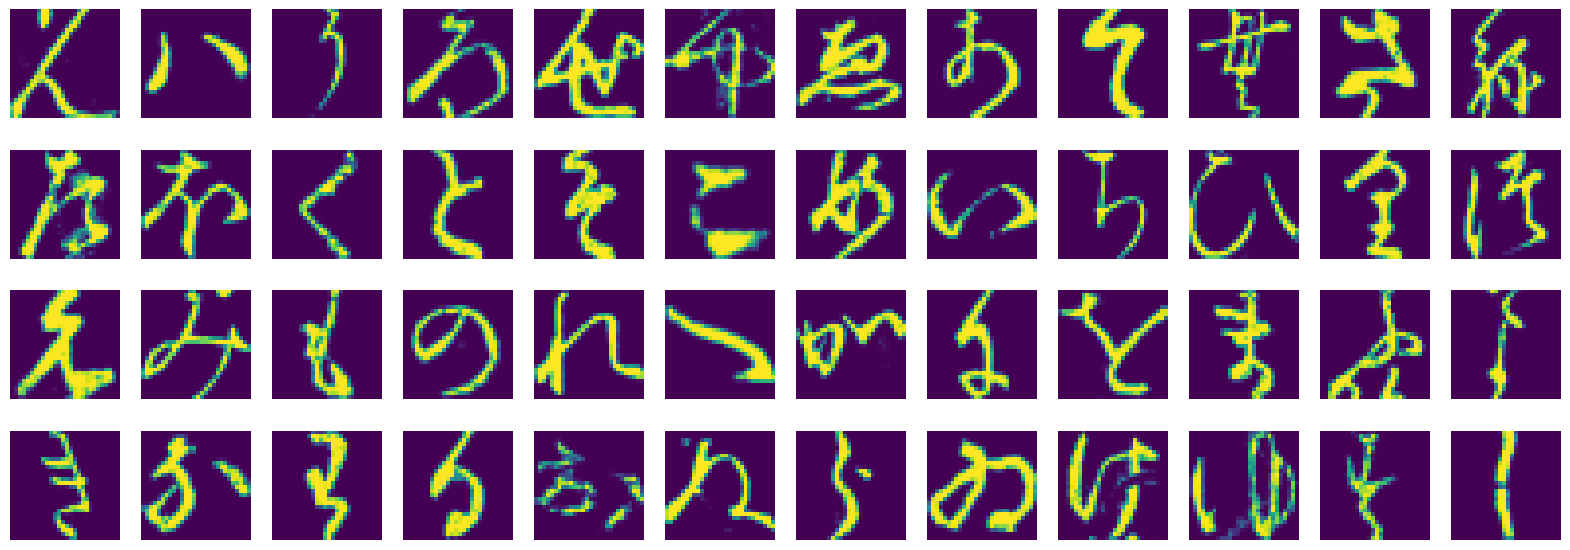

In [16]:
plt.figure(figsize=(20, 7))

for letter_id, keys in kmnist_img_label_map.items():
    ax = plt.subplot(4, 12, letter_id + 2)

    plt.imshow(img_kmnist[keys[4]])
    plt.axis("off")


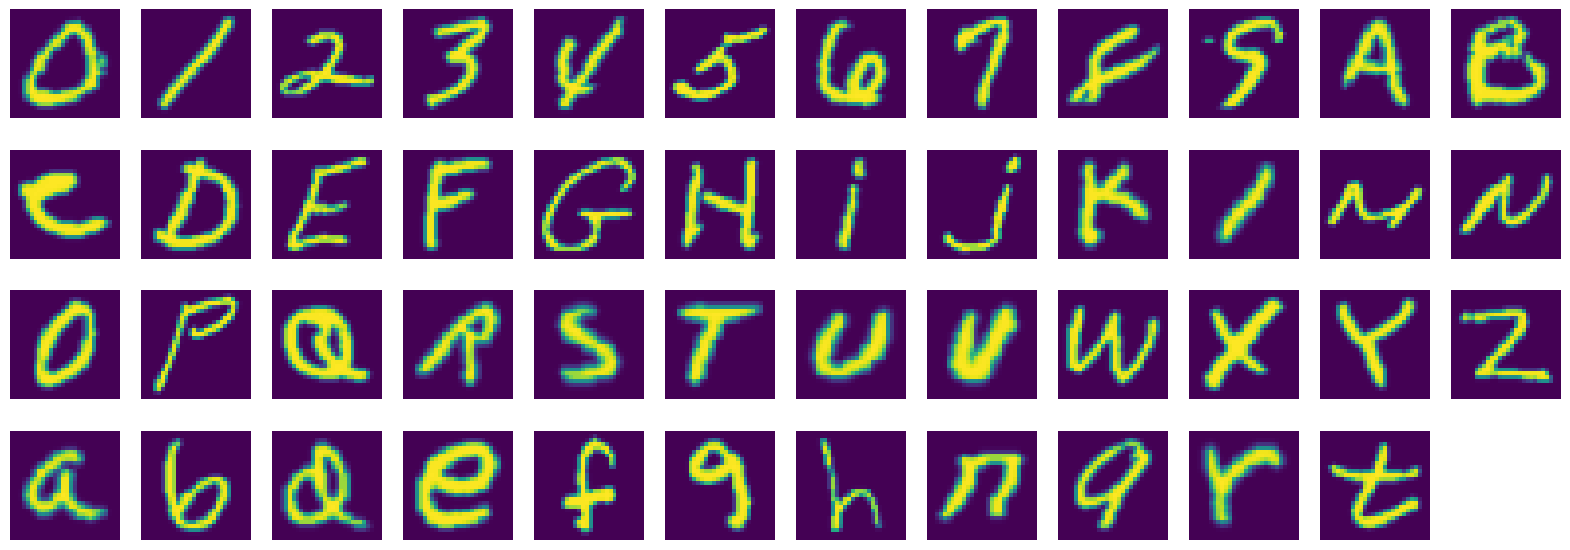

In [84]:
plt.figure(figsize=(20, 7))

for letter_id, keys in emnist_img_label_map.items():
    ax = plt.subplot(4, 12, letter_id + 1)

    plt.imshow(img_emnist[keys[4]])
    plt.axis("off")